# Integrating gene expression and chromatin accessibility of 10k PBMCs

This notebook demonstrates a basic application of `MuVI` on a single-cell RNA-seq dataset of peripheral blood mononuclear cells (PBMCs) from lupus patients [Kang et al., 2018](https://www.nature.com/articles/nbt.4042), where cells were either stimulated with Interferon-β or left untreated. 

In [1]:
# %load_ext nb_black

<IPython.core.display.Javascript object>

In [2]:
import os
import numpy as np
import pandas as pd
import scanpy as sc
import anndata as ad

<IPython.core.display.Javascript object>

In [3]:
import muvi

<IPython.core.display.Javascript object>

In [4]:
%matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

Using matplotlib backend: <object object at 0x7f0e54accf20>


<IPython.core.display.Javascript object>

In [5]:
# plotting settings
sns.set()
sns.set_theme()
sns.set_style("whitegrid")
sns.set_context("notebook")

<IPython.core.display.Javascript object>

Run a quick check if GPU(s) are available and select the least utilized GPU to perform the optimization.

In [6]:
try:
    gpu_idx = muvi.get_free_gpu_idx()
    print("Using GPU #%s" % gpu_idx)
    os.environ["CUDA_VISIBLE_DEVICES"] = str(gpu_idx)
except Exception as e:
    print(e)

Using GPU #3


<IPython.core.display.Javascript object>

We adopt the preprocessing from [Rybakov et al., 2020](https://doi.org/10.1101/2020.12.02.401182). First, we load the processed AnnData object from the `.h5ad` file:

In [7]:
adata = ad.read("../../../data/kang_pp.h5ad")
adata

AnnData object with n_obs × n_vars = 13576 × 979
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'stim', 'seurat_annotations', 'integrated_snn_res.0.5', 'seurat_clusters', 'condition', 'cell_type'
    uns: 'condition_colors', 'terms'
    varm: 'gene_set_mask'

<IPython.core.display.Javascript object>

## Informed Latent Decomposition

For this analysis we use the prior information from [Reactome](https://reactome.org/) which has already been stored inside `adata.varm['gene_set_mask']`.

In [8]:
model = muvi.MuVI(
    {"rna": adata.to_df()},
    prior_masks={"rna": adata.varm["gene_set_mask"].T},
)

2023-03-20 18:01:26,867 - muvi.core.models - WARNING - Running MuVI on a single view.
2023-03-20 18:01:26,869 - muvi.core.models - WARNING - No view names provided!
2023-03-20 18:01:26,870 - muvi.core.models - INFO - Setting the view names to the sorted list of dictonary keys in observations.
2023-03-20 18:01:26,870 - muvi.core.models - INFO - pd.DataFrame detected.
2023-03-20 18:01:26,871 - muvi.core.models - INFO - Storing the index of the view `rna` as sample names.
2023-03-20 18:01:26,872 - muvi.core.models - INFO - pd.DataFrame detected.
2023-03-20 18:01:26,873 - muvi.core.models - INFO - pd.DataFrame detected.
2023-03-20 18:01:26,873 - muvi.core.models - INFO - Storing the index of the mask `rna` as factor names.
2023-03-20 18:01:26,877 - muvi.core.models - INFO - Likelihoods set to `{'rna': 'normal'}`.
2023-03-20 18:01:26,931 - muvi.core.models - INFO - GPU available, running all computations on the GPU.


<IPython.core.display.Javascript object>

Train the model using stochastic variational inference (SVI) in order to utilize smaller batches of the whole dataset to avoid loading the whole dataset onto the GPU. The training takes around 6 minutes on a single Quadro RTX 5000 NVIDIA GPU.

In [9]:
n_epochs = 500
model.fit(
    batch_size=1000,
    n_epochs=n_epochs,
    n_particles=1,
    learning_rate=0.003,
    optimizer="clipped",
    verbose=1,
    seed=0,
)

2023-03-20 18:01:26,941 - muvi.core.models - INFO - Preparing model and guide...
2023-03-20 18:01:28,207 - muvi.core.models - INFO - Preparing optimizer...
2023-03-20 18:01:28,209 - muvi.core.models - INFO - Decaying learning rate over 6500 iterations.
2023-03-20 18:01:28,210 - muvi.core.models - INFO - Preparing SVI...
2023-03-20 18:01:28,211 - muvi.core.models - INFO - Preparing training data...
2023-03-20 18:01:28,262 - muvi.core.models - INFO - Using batches of size `1000`.
2023-03-20 18:01:28,264 - muvi.core.models - INFO - Setting training seed to `0`.
2023-03-20 18:01:28,265 - muvi.core.models - INFO - Cleaning parameter store.
2023-03-20 18:01:28,265 - muvi.core.models - INFO - Starting training...


  0%|                                                                                                                                                                                                      | 0/500 [00:00<?, ?it/s]

2023-03-20 18:01:29,042 - root - INFO - Guessed max_plate_nesting = 2


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [05:29<00:00,  1.52it/s, ELBO=8.91e+3]

2023-03-20 18:06:57,610 - muvi.core.models - INFO - Call `model._training_log` to inspect the training progress.


<IPython.core.display.Javascript object>

## Downstream Analysis

Once the training terminates, we may call `muvi.tl.foo` followed by `muvi.pl.foo` to apply different analysis tools and plot the results, similar to the usage principles of `scanpy`.

Under the hood, `muvi` stores every intermediate result in a `model._cache.factor_adata` such as variance explained by each factor, significance of each factor with respect to the prior information and so on.

In [10]:
# to speed up the process, use a random subsample to approximate the variance explained
r2_view, r2_factor, _ = muvi.tl.variance_explained(model, subsample=1000)
r2_view

2023-03-20 18:06:57,631 - muvi.tools.utils - INFO - Estimating `r2` with a random sample of 1000 samples.
2023-03-20 18:06:57,639 - muvi.tools.utils - WARNING - Cache has not yet been setup, initialising model cache.


{'rna': 0.6781757175922394}

<IPython.core.display.Javascript object>

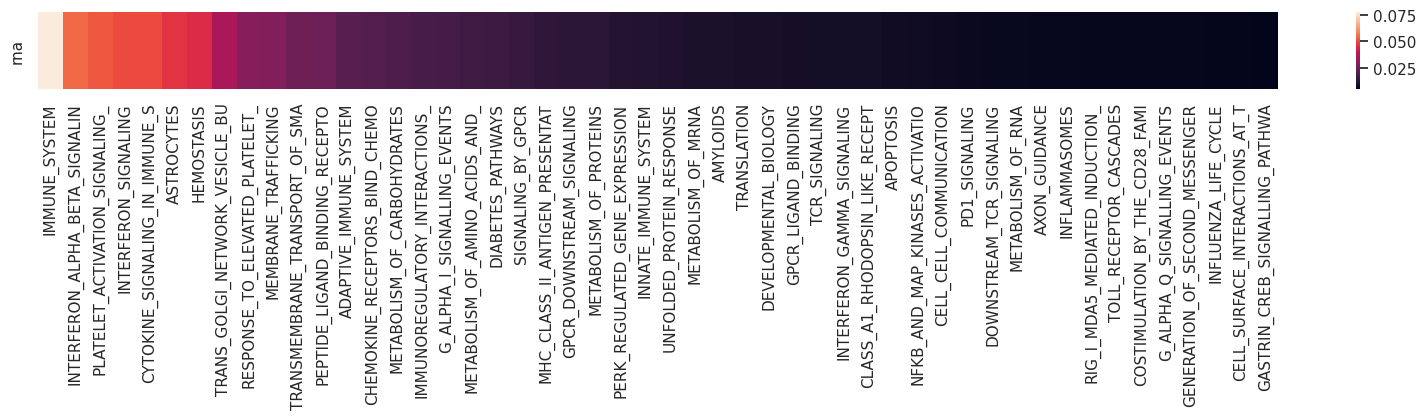

<AxesSubplot: >

<IPython.core.display.Javascript object>

In [11]:
muvi.pl.variance_explained(model)

Next, we perform a statistical test ([PCGSE](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4543476/)) to determine how well the inferred factors match the prior information representing each pathway. Here, we apply a correlation adjusted one-sided t-test, and correcting for multiple testing. 

Unless we provide other feature sets, e.g. [Gene Ontology](http://geneontology.org/), `muvi` automatically compares each inferred factor against its corresponding prior gene set annotation.

In [12]:
for sign in ["neg", "pos"]:
    muvi.tl.test(model, sign=sign)

2023-03-20 18:06:59,364 - muvi.tools.utils - WARNING - No feature sets provided, extracting feature sets from prior mask.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:10<00:00, 13.21it/s]

2023-03-20 18:07:09,625 - muvi.tools.utils - WARNING - No feature sets provided, extracting feature sets from prior mask.



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:10<00:00, 13.22it/s]


<IPython.core.display.Javascript object>

Now we may plot an overview of the most relevant factors by combining the variance explained and the results of the statistical test. Since we applied a one-sided hypothesis test, each significant factor is marked by a `(+)` or `(-)` indicating the significance direction. A factor may also be significant in both directions. However, we report the more significant direction based on the lower p-value.

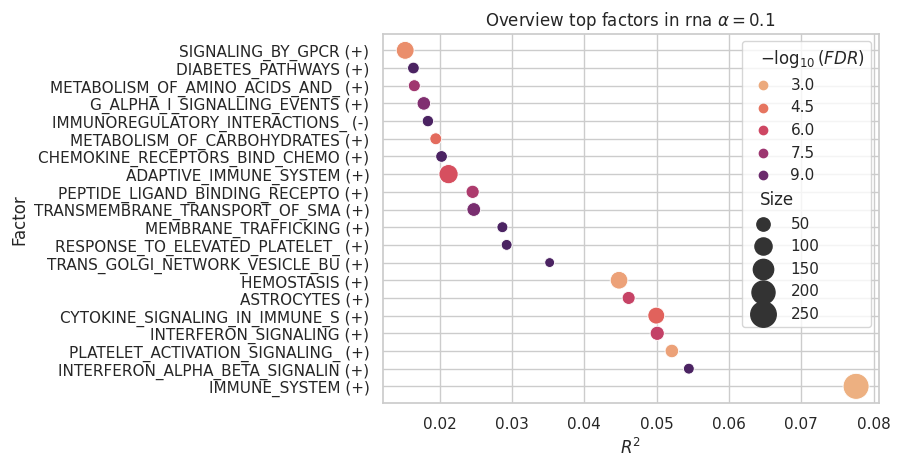

<IPython.core.display.Javascript object>

In [13]:
muvi.pl.factors_overview(
    model,
    one_sided=True,
    alpha=0.1,
    sig_only=False,
    adjusted=True,
    top=20,
    show=True,
)

In [14]:
# add obs metadata
model._cache.factor_adata.obs = adata.obs.copy()

<IPython.core.display.Javascript object>

After copying the metadata stored in `adata.obs`, we may perform a typical `scanpy` analysis such as computing a neighborhood graph in the latent space, applying a clustering algorithm on the pathway level, and embedding the neighborhood graph in two dimensions for visualization purposes.

Optionally, we may filter only the relevant factors before performing the steps mentioned above. This is useful to reduce the number of factors involved in the analysis by removing factors that explain little to no variance in the data.

In [15]:
muvi.tl.filter_factors(model)

2023-03-20 18:07:20,563 - muvi.tools.utils - INFO - Filtering down to 82 factors.
2023-03-20 18:07:20,567 - muvi.tools.cache - INFO - Factors filtered successfully.


True

<IPython.core.display.Javascript object>

Now we can proceed to perform clustering on top of the inferred and filtered latent space.

In [16]:
muvi.tl.neighbors(model)
muvi.tl.leiden(model)
muvi.tl.umap(model)

<IPython.core.display.Javascript object>

/home/aqoku/miniconda3/envs/muvi/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/aqoku/miniconda3/envs/muvi/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/aqoku/miniconda3/envs/muvi/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


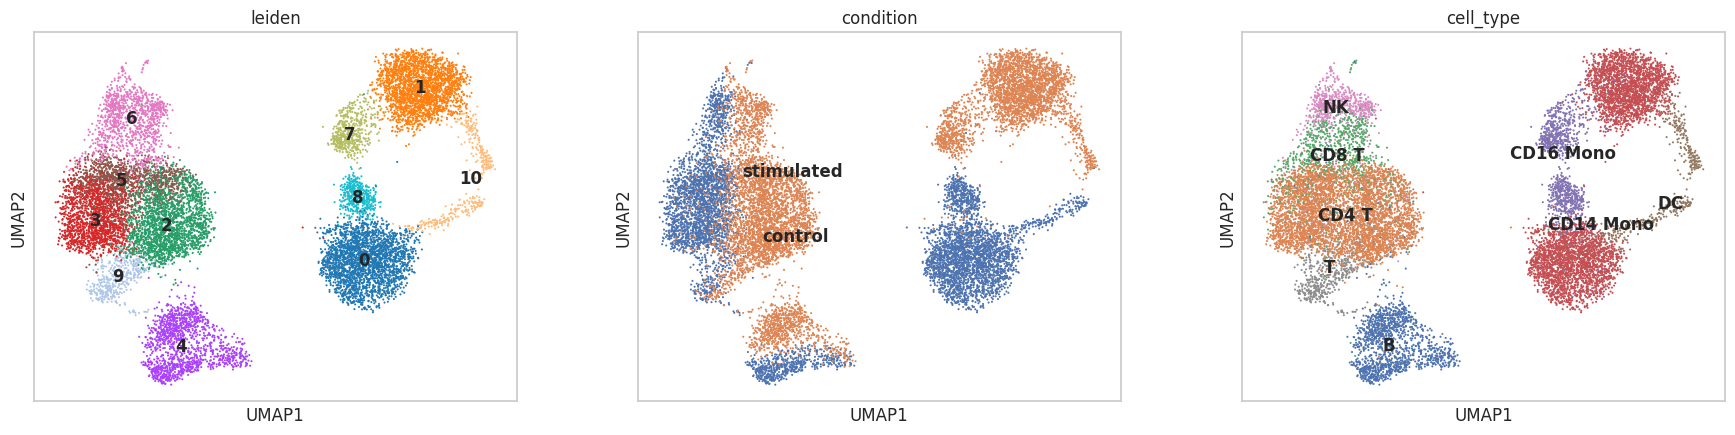

<IPython.core.display.Javascript object>

In [17]:
groupby = "leiden"
color = [groupby] + ["condition", "cell_type"]
muvi.pl.umap(model, color, legend_loc="on data")

The inferred latent space captures major axes of variation such as different cell types. Next, we look into specific factors (pathways) that explain variance between both conditions. 

In [18]:
muvi.tl.rank(model, "condition", method="wilcoxon")

/home/aqoku/miniconda3/envs/muvi/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/home/aqoku/miniconda3/envs/muvi/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(


<IPython.core.display.Javascript object>

2023-03-20 18:07:58,940 - muvi.tools.plotting - WARNING - dendrogram data not found (using `dendrogram_condition` as key). Running `muvi.tl.dendrogram` with default parameters. For fine tuning it is recommended to run `muvi.tl.dendrogram` independently.


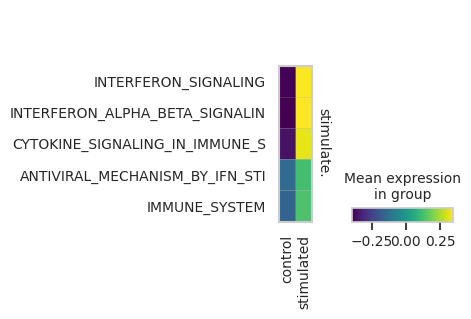

<AxesSubplot: >

<IPython.core.display.Javascript object>

In [19]:
muvi.pl.rank(
    model, n_factors=5, groups=["stimulated"], pl_type="matrixplot", swap_axes=True
)

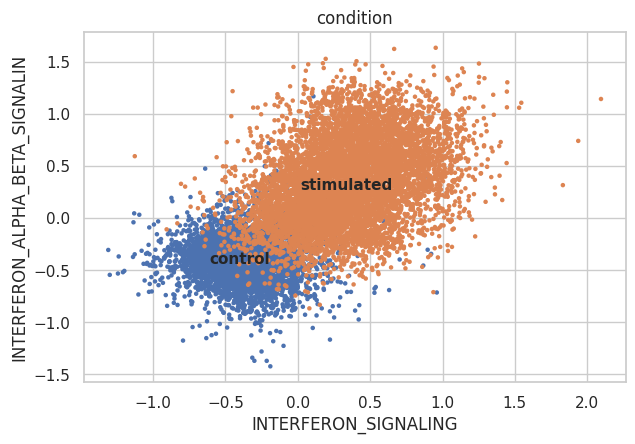

<IPython.core.display.Javascript object>

In [20]:
top_if_factors = ["INTERFERON_SIGNALING", "INTERFERON_ALPHA_BETA_SIGNALIN"]
muvi.pl.scatter(
    model,
    *top_if_factors,
    "condition",
    size=42,
    legend_loc="on data",
)

We may also explore the informed latent factors that are specific to particular cell types.

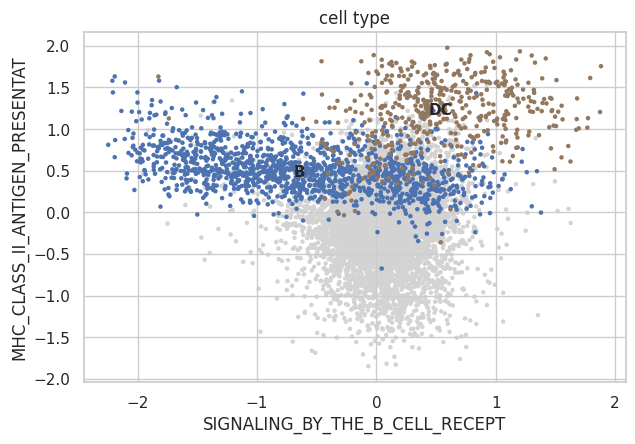

<IPython.core.display.Javascript object>

In [21]:
top_ct_factors = ["SIGNALING_BY_THE_B_CELL_RECEPT", "MHC_CLASS_II_ANTIGEN_PRESENTAT"]
muvi.pl.scatter(
    model,
    *top_ct_factors,
    "cell_type",
    groups=["B", "DC"],
    size=42,
    legend_loc="on data",
)

In [22]:
_ = muvi.tl.variance_explained_grouped(model, "cell_type")

<IPython.core.display.Javascript object>

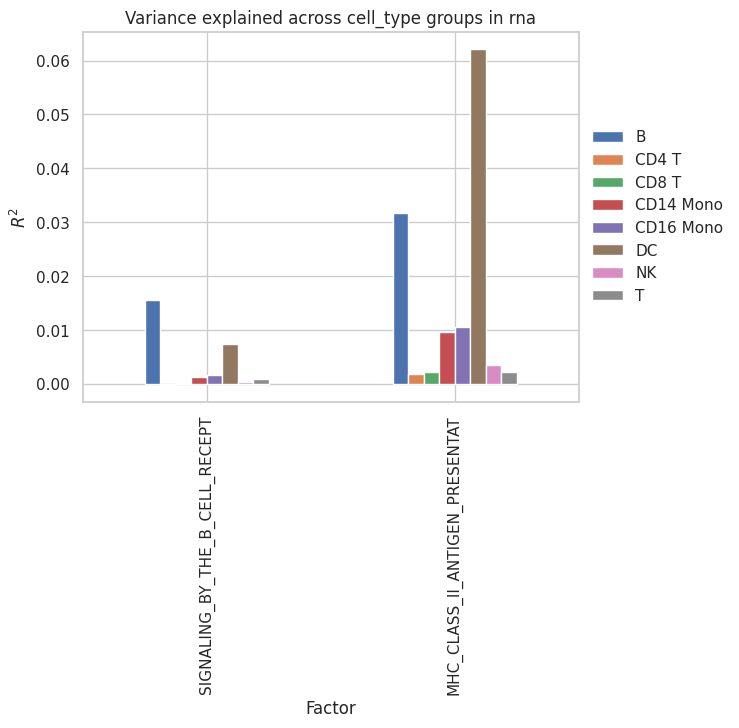

<AxesSubplot: title={'center': 'Variance explained across cell_type groups in rna'}, xlabel='Factor', ylabel='$R^2$'>

<IPython.core.display.Javascript object>

In [23]:
muvi.pl.variance_explained_grouped(
    model,
    top_ct_factors,
    stacked=False,
)

To inspect a single factor in a single view regarding its factors loadings, simply call `muvi.pl.inspect_factor`. The features originating from the prior gene set annotation are shown as annotated (black), whereas the new features added during training are shown as inferred (red). As a result, we obtain a data-driven refinement of the prior feature sets.

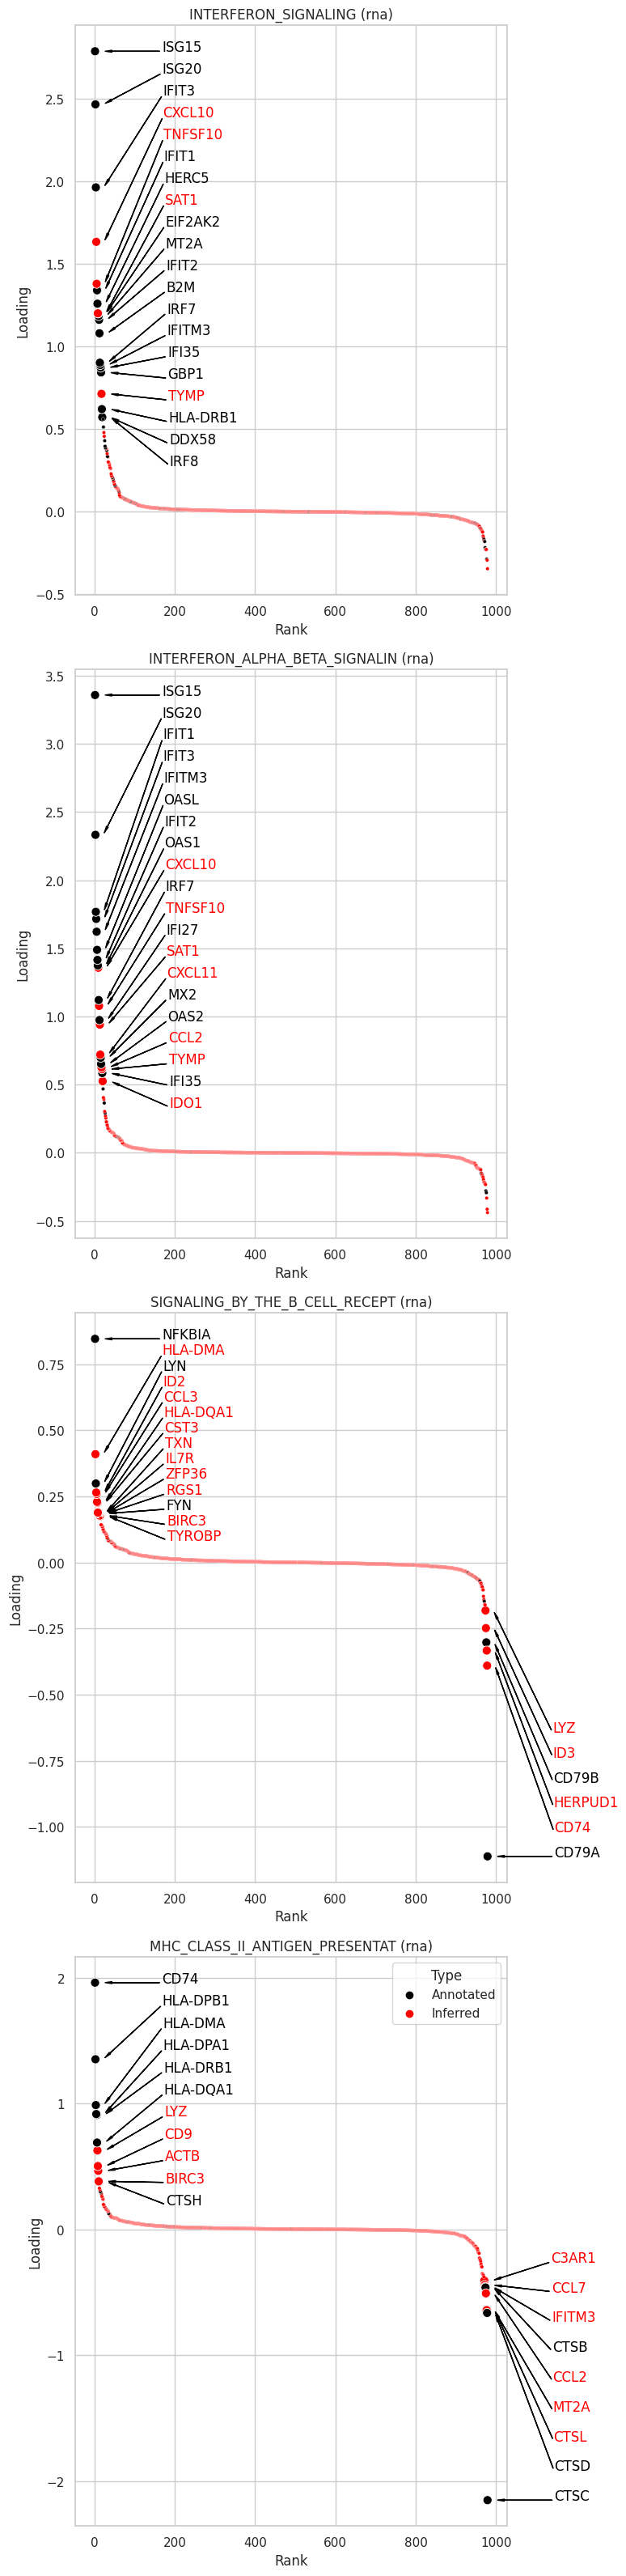

(<Figure size 800x3200 with 4 Axes>,
 array([[<AxesSubplot: title={'center': 'INTERFERON_SIGNALING (rna)'}, xlabel='Rank', ylabel='Loading'>],
        [<AxesSubplot: title={'center': 'INTERFERON_ALPHA_BETA_SIGNALIN (rna)'}, xlabel='Rank', ylabel='Loading'>],
        [<AxesSubplot: title={'center': 'SIGNALING_BY_THE_B_CELL_RECEPT (rna)'}, xlabel='Rank', ylabel='Loading'>],
        [<AxesSubplot: title={'center': 'MHC_CLASS_II_ANTIGEN_PRESENTAT (rna)'}, xlabel='Rank', ylabel='Loading'>]],
       dtype=object))

<IPython.core.display.Javascript object>

In [24]:
muvi.pl.inspect_factor(
    model,
    top_if_factors + top_ct_factors,
    top=20,
)

Head out to [this notebook](3a_single-cell_multi-omics_integration.ipynb) for an application of `MuVI` on a single-cell multiome dataset.